In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
%matplotlib inline

In [7]:
words = pd.read_table('names.txt', header=None, names=['name'])
words[:5]

,name
0,emma
1,olivia
2,ava
3,isabella
4,sophia


In [9]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words['name']))))
char_to_idx = {s:i+1 for i,s in enumerate(chars)}
char_to_idx['.'] = 0
idx_to_char = {i:s for s,i in char_to_idx.items()}
vocab_size = len(idx_to_char)
print(idx_to_char)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [191]:
def build_dataset(words, block_size = 3):
    # first, initialize X and Y sets
    X, Y = [], []

    for w in words:
        # use the 3 previous characters to predict the next character (similar to trigram approach):
        context = [0] * block_size
        for ch in w + '.':
            idx = char_to_idx[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    

    X, Y = torch.tensor(X), torch.tensor(Y)

    return X, Y

def build_model(vocab_size, n_emb, n_hidden, block_size = 3):
    # initialize the parameters of the model
    C = torch.randn((vocab_size, n_emb))

    # to initialize these, let's use Kaiming's Normalization numbers
    W1 = torch.randn((n_emb * block_size, n_hidden)) * (5/3)/(n_emb * block_size) ** 0.5
    # b1 = torch.randn(n_hidden) * 0.1
    W2 = torch.randn((n_hidden, vocab_size)) * 0.1
    b2 = torch.randn(vocab_size) * 0.01
    bngain = torch.ones((1, n_hidden))
    bnbias = torch.zeros((1, n_hidden))    
    bnmean_running = torch.zeros((1, n_hidden))
    bnstd_running = torch.ones((1, n_hidden))

    return [C, W1, W2, b2, bngain, bnbias], [bnmean_running, bnstd_running]

def train_model(Xtr, Ytr, Xte, Yte, grad_parameters, running_parameters, batch_size = 32, learning_rate = 0.1, epochs = 20000, return_running = False):
    C, W1, W2, b2, bngain, bnbias = grad_parameters
    bnmean_running, bnstd_running = running_parameters

    loss_i = []

    for p in grad_parameters:
        p.requires_grad = True

    for _ in range(epochs):
        # implement stochastc gradient descent to train the model
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))

        # embedding vector
        emb = C[Xtr[ix]]

        # first layer
        embcat = emb.view(emb.shape[0], -1)

        # make the numbers roughy Gaussian with batch normalization
        hpreact = embcat @ W1 #+ b1
        bn_mean = hpreact.mean(dim = 0, keepdim = True)
        bn_std = hpreact.std(dim = 0, keepdim = True)
        hpreact = bngain * (hpreact - bn_mean) / bn_std + bnbias

        with torch.no_grad():
            bnmean_running = 0.99 * bnmean_running + 0.01 * bn_mean
            bnstd_running = 0.99 * bnstd_running + 0.01 * bn_std

        h = torch.tanh(hpreact)

        # second layer (non-linaerity)
        logits = (h @ W2) + b2

        # cross entropy loss
        loss = F.cross_entropy(logits, Ytr[ix])

        # make sure gradients aren't adding on top of each other
        for p in grad_parameters:
            p.grad = None
        
        # backwards pass
        loss.backward()

        # update parameters
        if _ // 10000 == 1:
            learning_rate = 0.01

        for p in grad_parameters:
            p.data -= learning_rate * p.grad

        # if _ % 1000 == 0:
        #     print(f'{_:7d}/{epochs:7d}: {loss.item():.4f}')
        loss_i.append(np.log10(loss.item()))

    # plot the loss
    plt.plot(loss_i)

    # find total loss based on Yte
    emb = C[Xte]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bn_mean) / bn_std + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yte)

    if return_running:
        return loss, [bnmean_running, bnstd_running]
    else:
        return loss


In [192]:
import random 

all_names = words['name']
random.shuffle(all_names)
n1 = int(0.8 * all_names.shape[0])
n2 = int(0.9 * all_names.shape[0])

Xtr, Ytr = build_dataset(all_names[:n1])
Xva, Yva = build_dataset(all_names[n1:n2])
Xte, Yte = build_dataset(all_names[n2:])

In [193]:
grad_parameters, running_parameters = build_model(27, 10, 300)

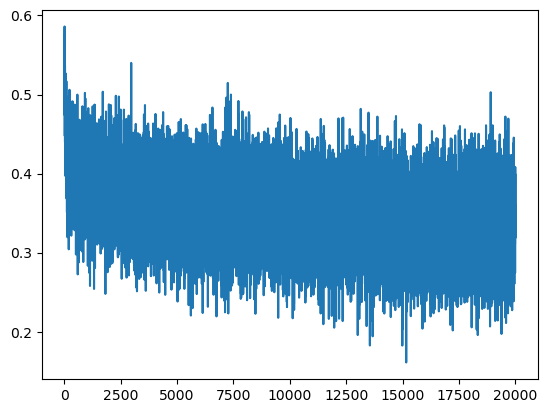

In [194]:
loss, running_params = train_model(Xtr, Ytr, Xva, Yva, grad_parameters, running_parameters, return_running = True) 

In [196]:
C, W1, W2, b2, bngain, bnbias = grad_parameters

# we cam use the running values initialized in the training function instead of explicitly calling them
bnmean_running, bnstd_running = running_params
epsilon = 1e-5

In [199]:
@torch.no_grad() # this decorator disables gradient tracking

def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xva, Yva),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 #+ b1
  hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running + epsilon) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.1669249534606934
val 2.181821584701538
test 2.198303699493408


Some ways we've improved the mode so far:
1) Fixing the softmaxing
2) Adjust the randomness of the parameters by making them smaller, inadvertently also fixing the tanh layer
2) Fixing the tanh layer

In [229]:
# Samplign from the Neural Network

for _ in range(20):
    output = []
    context = [0] * 3
    while True:
        emb = C[torch.tensor(context).view(1, -1)]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running + epsilon) + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1)
        idx = torch.multinomial(p, 1).item()
        if idx == 0:
            break
        output.append(idx)
        context = context[1:] + [idx]
        if idx == 0:
            break

    # print(output)
    print(''.join(idx_to_char[i] for i in output))

dee
abriana
ameah
ryce
nomia
aylinden
nestor
oluwaprez
ableantyn
kalakonnellae
rohiannet
harani
jnen
ioghedmeruto
shart
han
tchis
novannahdise
sroanen
braedyn


In [216]:
# one problem with the tanh, sigmoid, and RELU activation functions are that they have the potential to squash an entire neuron, which is called the vanishing gradient problem.
# One activation function to solve this problem is by 

Let's start PyTorchifying our code

In [250]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

block_size = 3
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]


with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [251]:

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3141


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 2.88%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.59%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.28%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 1.94%


Text(0.5, 1.0, 'activation distribution')

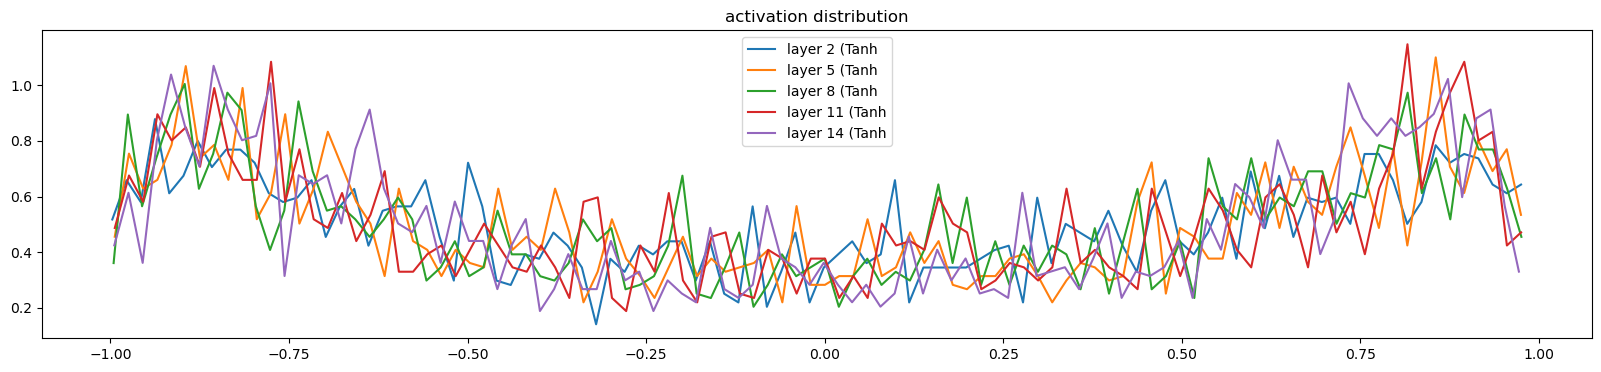

In [252]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.244258e-03
layer 5 (      Tanh): mean -0.000000, std 2.768698e-03
layer 8 (      Tanh): mean -0.000000, std 2.477943e-03
layer 11 (      Tanh): mean -0.000000, std 2.356597e-03
layer 14 (      Tanh): mean -0.000000, std 2.332689e-03


Text(0.5, 1.0, 'gradient distribution')

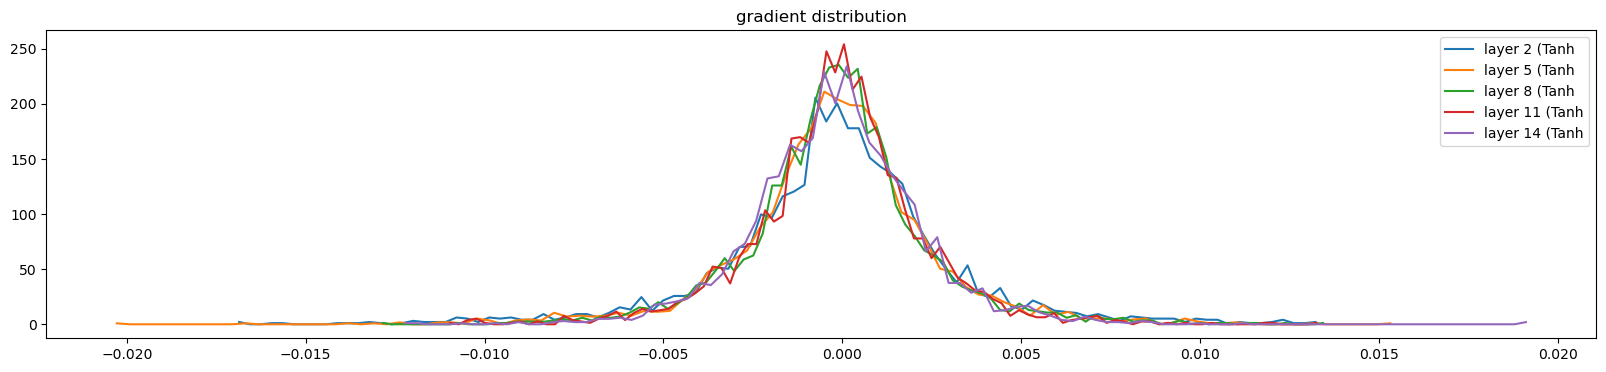

In [253]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


weight   (27, 10) | mean +0.000000 | std 1.054939e-02 | grad:data ratio 1.053852e-02
weight  (30, 100) | mean +0.000075 | std 8.191847e-03 | grad:data ratio 2.620648e-02
weight (100, 100) | mean -0.000003 | std 7.352913e-03 | grad:data ratio 4.397433e-02
weight (100, 100) | mean -0.000004 | std 6.206828e-03 | grad:data ratio 3.679849e-02
weight (100, 100) | mean +0.000034 | std 5.709380e-03 | grad:data ratio 3.401350e-02
weight (100, 100) | mean +0.000017 | std 5.211995e-03 | grad:data ratio 3.104346e-02
weight  (100, 27) | mean -0.000005 | std 1.118237e-02 | grad:data ratio 6.706975e-02


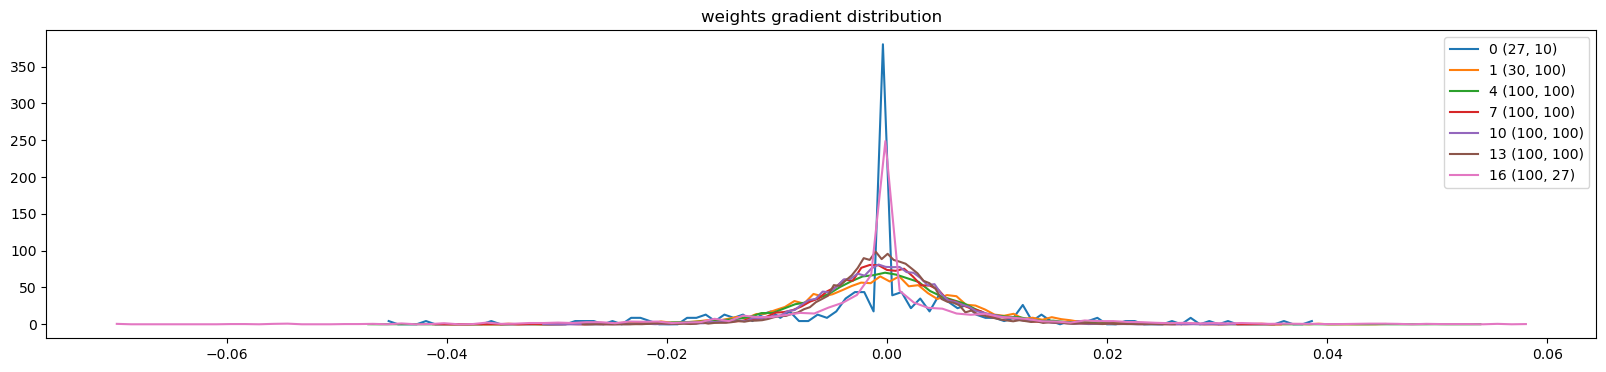

In [254]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  # only print the weights
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

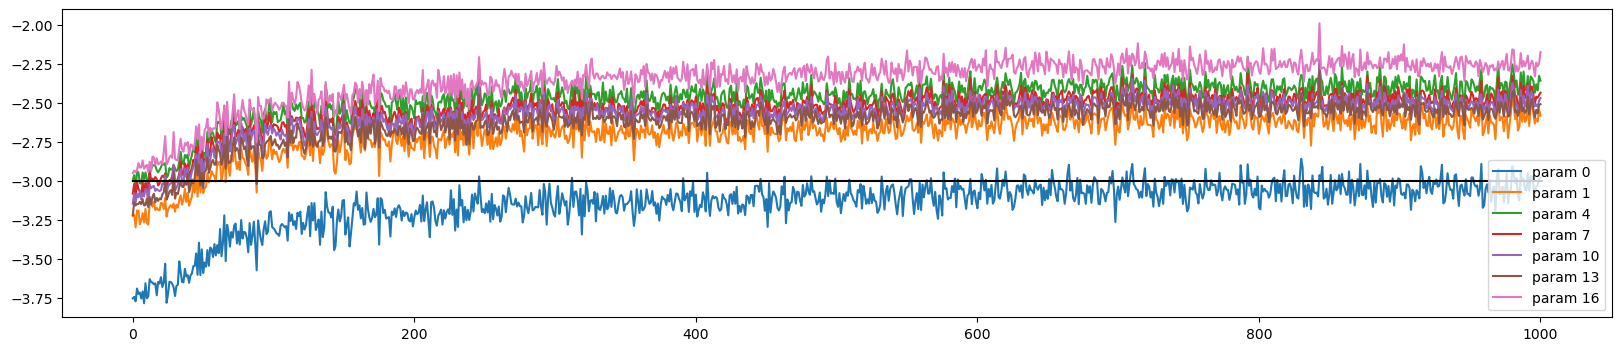

In [255]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [256]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xva, Yva),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.413316249847412
val 2.4167308807373047


In [294]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(idx_to_char[i] for i in out)) # decode and print the generated word

kana.
kyanna.
jaylan.
wen.
earee.
mer.
nair.
klylanle.
.
hala.
xtan.
verc.
kiwhezyan.
iui.
alee.
mshe.
ltida.
sar.
biahitn.
misala.
